# RISM - A Gentle Introduction

We are going to write a Python implementation of the extended RISM equation with the goal of computing the direct, indirect and total correlation function along with the radial distribution function.

First, we import the libraries we will be needing:

In [1]:
import numpy as np
from scipy.fftpack import dstn, idstn
from scipy.special import erf
import matplotlib.pyplot as plt

First, we need to set up our problem domain. While the RISM equations are written as continuous functions $r$ (e.g. $c(r)$), computationally we solve them on a discretised grid.

We'll set up a discrete domain of length (or radius since we are working with spherically symmetric functions) $r = 15\, Å$ partitioned into $N = 100$ points. The resulting grid spacing is given by $\Delta r = \frac{r}{N}$.

In [2]:
r = 15.0
N = 100
dr = r / N

We also want to set up a grid spacing for our Fourier-space grid such that $\Delta r \Delta k = \frac{\pi}{N}$

In [3]:
dk = 2.0 * np.pi / (2.0 * N * dr)

Lets check the equality we stated above:

In [4]:
np.isclose(dr * dk, np.pi / N)

True

We use `np.isclose()` here because we are comparing floating point numbers. Using `==` would not work since there is always some precision loss with floats. You need to compared them within tolerances instead.

We can use these to generate our real and Fourier-space midpoint grids.

In [5]:
r_grid = np.arange(0.5, N, 1.0) * dr
k_grid = np.arange(0.5, N, 1.0) * dk

Now that we have our problem domain set up, we can focus on solving a particular problem. We're going to look at solving RISM for a simple Lennard-Jones Argon liquid system.

We first need to set up the thermodynamical state of the system and the unit systems we're going to use. We'll be working with energies in kJ / mol.

In [6]:
T = 300.0 # Kelvin
kB = 8.314462618e-3 # kJ / mol / K
beta = 1 / T / kB # Thermodynamic Beta

We also need to define the parameters and coordinates for Argon, as well as its number density. 

In [7]:
params = [[0.99773551416, 3.4, 0.0]]
epsilon = 0.99773551416
sigma = 3.4
coords = np.array([0.0, 0.0, 0.0])
rho = 0.021017479720736955

We need to tabulate the LJ potential with the above parameters. We define a function to evaluate the potential over a grid, and then we plot the potential.

In [8]:
def LJ(epsilon, sigma, r):
    return 4.0 * epsilon * ( np.power( (sigma / r), 12) - np.power( (sigma / r), 6) )

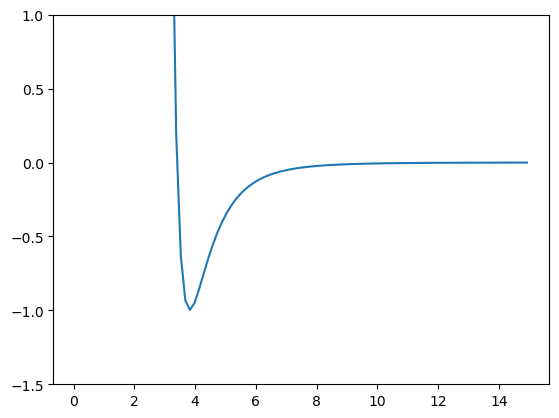

In [9]:
ur = LJ(epsilon, sigma, r_grid)

plt.plot(r_grid, ur)
plt.ylim([-1.5, 1.0])
plt.show()

One aspect of the RISM equation that we need to consider is the intramolecular correlation function $\omega(k)$. In the case of a simple liquid, $\omega(k) = 1$, in which case we the RISM equation reduces to the Ornstein-Zernike (OZ) equation.
We'll implement the full RISM equation, but we will set $\omega(k)$ to 1 for the case our current system.

In [10]:
wk = np.ones(N)

Another aspect is the closure. The closure is what relates our unknowns ($h(r)$ and $c(r)$), in a sense "closing" the RISM equation.
Generally the closure in terms of $c(r)$ is $$ c(r) = e^{-\beta u(r) + t(r) - B(r)} - t(r) - 1 $$ where $B(r)$ is the bridge function - something that we need to approximate - and $t(r) = h(r) - c(r)$ is the indirect correlation function.

We're going to use the simplest approximation, $B(r) = 0$. This is the Hypernetted Chain (HNC) closure.

In [11]:
def HNC(beta, ur, tr):
    return np.exp(-beta * ur + tr) - 1.0 - tr

The final detail before we implement the RISM equation is that we need to be able to transform our correlation functions into Fourier-space and back.
We use the Fourier transforms of spherically symmetric functions:

$$ f(k) = 4 \pi \int_0^\infty f(r) r^2 \frac{\sin(kr)}{kr} dr $$

and the inverse:

$$ f(r) = \frac{1}{2 \pi^2} \int_0^\infty f(k) k^2 \frac{\sin(kr)}{kr} dk $$

The function $J_0(kr) = \frac{\sin(kr)}{kr}$ is the zeroth-order spherical Bessel function of the first kind, so sometimes these transforms are called Fourier-Bessel (or Hankel) transforms.

This can neatly be related to the Fourier sine transform:

$$ f(k) = \int_0^\infty f(r) \sin(kr) dr $$

$$ f(r) = \frac{2}{\pi} \int_0^\infty f(k) \sin(kr) dk $$

So that the fourier transform of the spherically symmetric function $f(r)$ is just the Fourier sine transform of the function $f(r) \cdot r$

Scipy has discrete sine transform functions we can use.

In [12]:
def fbt(fr, r, k, dr):
    return 2.0 * np.pi * dr * dstn(fr * r, type=4, axes=[0]) / k

def ifbt(fk, r, k, dk):
    return dk / 4.0 / np.pi / np.pi * idstn(fk * k, type=4, axes=[0]) / r

We have all the key parts to solve the RISM equation now.
The equation in Fourier-space is $$h(k) = \omega(k) * c(k) * \omega(k) - \rho * \omega(k) * c(k) * h(k)$$
We can rearrange this for $h(k)$ $$h(k) = [1 - \rho * \omega(k) * c(k)]^{-1} \omega(k) * c(k) * \omega(k)$$

For brevity, I'm going to drop the function argument $(k)$
$$h = [1 - \rho\omega c]^{-1} \omega c \omega$$

We're interested in calculating the indirect correlation function $t(r)$ $$t = [1 - \rho\omega c]^{-1} \omega c \omega - c$$

In [13]:
def RISM(cr, w, p, r, k, dr, dk):
    # Transform c(r) to c(k)
    ck = fbt(cr, r, k, dr)
    # Solve the RISM equation for t(k)
    tk = w * ck * w / (1.0 - p * w * ck) - ck
    # Transform t(k) to t(r)
    tr = ifbt(tk, r, k, dk)
    return tr

We have all the equations we need to perform a single closure and RISM calculation. Now we need to numerically solve this problem.

The RISM equation is an integro-differential equation, and is posed to be solved using fixed-point iteration (i.e. the self-consistent approach used in electronic structure theory e.g. Hartree-Fock).

We set some initial guess for $t_0(r)$, and use that as input into the closure and RISM equation, and get a new value out. If we represent the closure and RISM equation as an operator $F(\cdot)$ on $t(r)$ then we get a value of $F(t(r))$.

We can then mix this new value with our initial value to obtain a new solution for $t(r)$ $$t_1(r) = \alpha F(t_0(r))  + (1 - \alpha) t_0(r) $$

More generally $$t_{k+1}(r) = \alpha F(t_k(r)) + (1 + \alpha) t_k(r)$$

where $\alpha$ is a dampening parameter. The lower this is, the stiffer our iteration process is (because we're including more of the previous solution than the current).
We keep iterating this and check the difference between current and previous solutions until that difference is below some tolerance $\zeta$ $$ |t_{k+1}(r) - t_{j}(r)| < \zeta $$

Once the difference is below this tolerance, the calculation is finished.

We use an initial guess of $t(r) = 0$ and a tolerance of $\zeta = 1\times10^{-8}$

In [14]:
# Setting up parameters for iterations
tolerance = 1e-8
max_steps = 1000
step = 0
alpha = 0.5

# Setting up initial guess
tr = np.zeros(N)

while step < max_steps:
    # Store previous t(r)
    tr_prev = tr

    # t(r) -> c(r) from closure
    cr = HNC(beta, ur, tr)

    # c(r) -> F(t(r)) from RISM equation
    f_tr = RISM(cr, wk, rho, r_grid, k_grid, dr, dk)

    tr_new = alpha * f_tr - (1.0 - alpha) * tr_prev

    diff = dr * np.sqrt(np.power(tr_new - tr_prev, 2.0).sum()) / N

    tr = tr_new

    print("Iteration: {step} Diff: {diff}".format(step=step, diff=diff))

    if diff < tolerance:
        break

    step += 1

Iteration: 0 Diff: 0.06714724847113958
Iteration: 1 Diff: 0.6074696113840574
Iteration: 2 Diff: 0.06042672098862835
Iteration: 3 Diff: 0.25710453723703774
Iteration: 4 Diff: 0.03691966609069286
Iteration: 5 Diff: 0.12302245366645614
Iteration: 6 Diff: 0.01939994402126663
Iteration: 7 Diff: 0.05560207665595962
Iteration: 8 Diff: 0.009503940663800226
Iteration: 9 Diff: 0.023544055691571586
Iteration: 10 Diff: 0.004377061269876553
Iteration: 11 Diff: 0.009259166692879295
Iteration: 12 Diff: 0.0018920145086183116
Iteration: 13 Diff: 0.0034375930246069997
Iteration: 14 Diff: 0.000759343065313528
Iteration: 15 Diff: 0.001166010235955528
Iteration: 16 Diff: 0.00027533444159380527
Iteration: 17 Diff: 0.00033883976623583223
Iteration: 18 Diff: 8.389944284301065e-05
Iteration: 19 Diff: 9.974496196544363e-05
Iteration: 20 Diff: 0.00010839932995654333
Iteration: 21 Diff: 2.862567530324768e-05
Iteration: 22 Diff: 9.282331630455776e-05
Iteration: 23 Diff: 8.782438850038488e-06
Iteration: 24 Diff: 6.

Once solved, we can use the calculated correlation functions to calculate the radial distribution function and plot it.

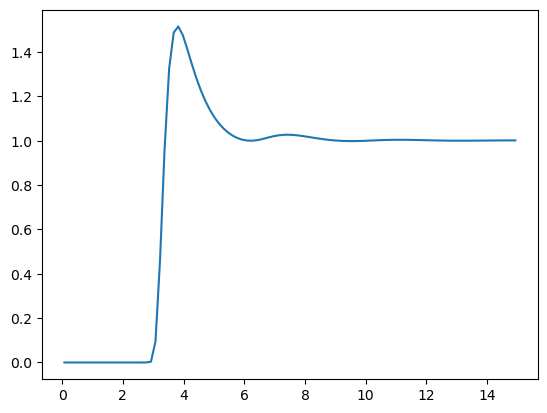

In [15]:
# Get c(r) from the computed t(r)
cr = HNC(beta, ur, tr)

# Get h(r)
hr = tr + cr

# Get and plot g(r)

gr = hr + 1

plt.plot(r_grid, gr)
plt.show()